# Hi-Res capable style transfer in Pytorch
[Source Repository](https://gitlab.com/gerardrbentley/style-transfer-methods-in-pytorch)

Hi-Res Network Based on [High-Resolution Network for Photorealistic Style Transfer](https://arxiv.org/pdf/1904.11617.pdf): their code is available at this [Github Repo](https://github.com/limingcv/Photorealistic-Style-Transfer)

Transformer Network from [Pytorch Fast Neural Style Example](https://github.com/pytorch/examples/tree/master/fast_neural_style)

# 1. Fetch files from repo

In [1]:
!git clone -s https://github.com/gerardrbentley/Style-Transfer-Methods-in-Pytorch.git styling
%cd styling
!ls

Cloning into 'styling'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 23 (delta 2), reused 23 (delta 2), pack-reused 0
Unpacking objects: 100% (23/23), done.
/content/styling
__init__.py	     pytorch_models  sample_input_and_output
lightning_styler.py  README.md	     utils.py


# 2. Upload a 'Content Image' to style and a 'Style Image' to copy the style from

`.jpg`, `.jpeg`, `.JPG`, `.png` should all work, probably others

The Google colab uploader seems a little finicky, I believe you need to run this cell twice (once per file), and just hit the play button again if it doesn't seem to work. You can view the current folder on the left (it also has a refresh button if it hasn't updated)

The simplest file accessing for this notebook means having your two images in the `styling/` folder (i.e. `styling/headshot.png` and `styling/artsy.png`. Using this `Choose Files` button should upload them into this folder.

Even simpler is skipping the uploading and just using the content photo of me in `styling/sample_input_and_output/0_content.png`

In [3]:
from google.colab import files

uploaded = files.upload()

Saving wolf.jpg to wolf.jpg


# 3. Python Prep

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch import optim
import imageio

import numpy as np

import utils
from pytorch_models.transformer_net import TransformerNet
from pytorch_models.vgg_extractor import Vgg16
from pytorch_models.hrnet import HRNet
%matplotlib inline
import matplotlib.pyplot as plt

SEED = 4747
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
# You may need to edit your Runtime -> Change Runtime Type to use GPU in Colab
DEVICE = 'cuda'
# Initial Learning Rate; Constant learning rate was most successful for me
#   Using a stepping lr decrease has been used in other implementations
LEARNING_RATE = 0.001
# Scaling the style image will emphasize different features
STYLE_SCALE = 1.0
CONTENT_SCALE = 1.0
# Weight different vgg activation layers differently for style loss (require 5 values)
LAYER_WEIGHTS = [1.0, 1.0, 1.0, 1.0, 1.0]
# Probably need fewer with different loss weighting
# Can go to 10,000 or more if you're more patient
TOTAL_STEPS = 3000
PRINT_EVERY = 300

# Most Important: Weights for Loss terms. These are from PyTorch's example, 
#    different loss functions yield different results
STYLE_WEIGHT = 1e10
CONTENT_WEIGHT = 1e5

# Have not tested on larger on Colab. input and output size of the network
IMAGE_SIZE = 256

# From PIL image to Torch Tensor
# Multiplication for imagenet mean and std normalize
transform_no_resize = transforms.Compose([
  transforms.ToTensor(),
  transforms.Lambda(lambda x: x.mul(255))
])
transform_with_resize = transforms.Compose([
  transforms.Resize(IMAGE_SIZE),
  transforms.CenterCrop(IMAGE_SIZE),
  transform_no_resize
])

print('All Set with HyperParams')

All Set with HyperParams


# 4. Image Prep

In [3]:
# Default from Gitlab repo, change to "./your_image_name.png" if you uploaded 
#   images in the ./styling/ folder
STYLE_FILE = "./sample_input_and_output/bastion.jpg"
CONTENT_FILE = "./sample_input_and_output/0_content.png"

style_image_load = utils.load_image(STYLE_FILE, scale=STYLE_SCALE)
print(type(style_image_load))
style_image_transform = transform_no_resize(style_image_load)
print(type(style_image_transform), style_image_transform.min(), style_image_transform.max())
# Uses Imagenet mean and std
style_image_input = utils.normalize_batch(style_image_transform).unsqueeze(0)
print(type(style_image_input), style_image_input.min(), style_image_input.max())

content_image_input = utils.load_image(CONTENT_FILE, scale=CONTENT_SCALE)
content_image_input = transform_with_resize(content_image_input)
content_image_input = content_image_input.unsqueeze(0)
print(content_image_input.shape)
print('Images loaded')

<class 'PIL.Image.Image'>
<class 'torch.Tensor'> tensor(0.) tensor(255.)
<class 'torch.Tensor'> tensor(-2.1179) tensor(2.4286)
torch.Size([1, 3, 256, 256])
Images loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


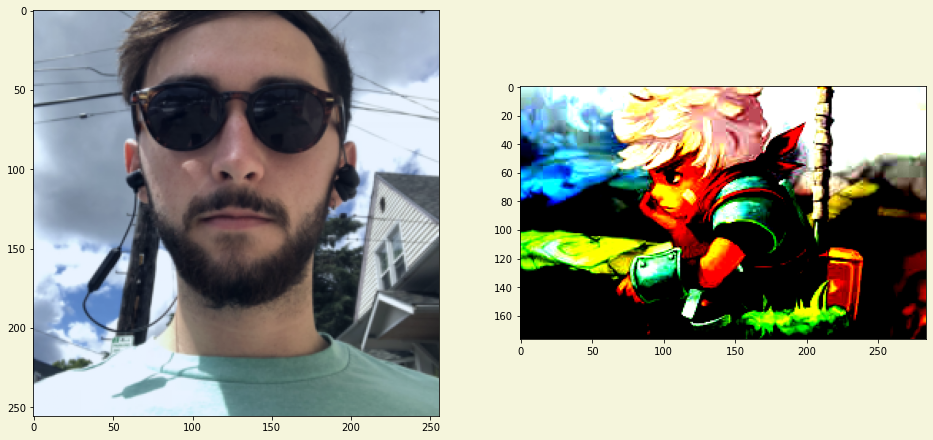

In [4]:
_, axes = plt.subplots(1, 2, figsize=(16,9), facecolor='beige')
axes = axes.flatten()
axes[0].imshow(content_image_input.div(255).squeeze(0).permute(1,2,0).numpy())
axes[1].imshow(style_image_input.squeeze(0).permute(1,2,0).numpy())
plt.show()

# 5. Prep Models and get style image features

In [5]:
feature_extractor = Vgg16(requires_grad=False).to(DEVICE)

# or style_model = TransformerNet().to(DEVICE)
style_model = HRNet().to(DEVICE)

style_image_features = feature_extractor(style_image_input.to(DEVICE))
style_image_gram_matrix = [utils.gram_matrix(y) for y in style_image_features]

content_image_input = content_image_input.to(DEVICE).requires_grad_(False)
content_image_features = feature_extractor(utils.normalize_batch(content_image_input, inplace=False))

optimizer = torch.optim.Adam(style_model.parameters(), lr=LEARNING_RATE)
# LR Scheduler would go here


# or target = torch.randn_like(content_image_input).requires_grad_(True)
target = content_image_input.clone().requires_grad_(True)
print(content_image_input.shape)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



torch.Size([1, 3, 256, 256])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 299 steps. Total loss: 1955536.25. Style Loss: 1377257.625. Content Loss: 578278.5625


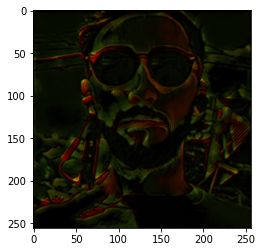

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 599 steps. Total loss: 1184971.0. Style Loss: 672209.0. Content Loss: 512761.96875


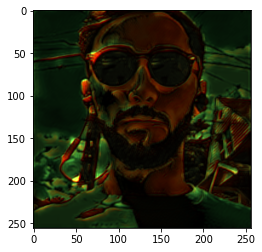

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 899 steps. Total loss: 886249.75. Style Loss: 430720.5625. Content Loss: 455529.21875


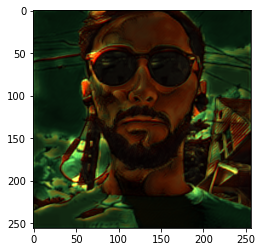

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 1199 steps. Total loss: 726781.375. Style Loss: 305983.09375. Content Loss: 420798.25


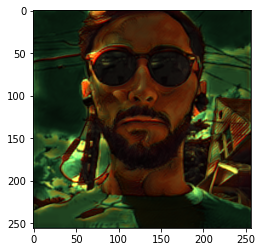

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 1499 steps. Total loss: 633446.0625. Style Loss: 238237.390625. Content Loss: 395208.65625


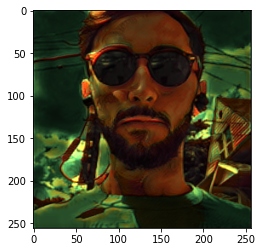

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 1799 steps. Total loss: 584984.0. Style Loss: 203404.765625. Content Loss: 381579.25


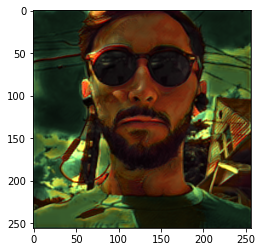

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 2099 steps. Total loss: 530785.8125. Style Loss: 169552.09375. Content Loss: 361233.71875


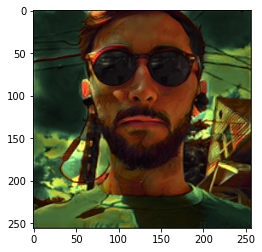

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 2399 steps. Total loss: 500890.5625. Style Loss: 152425.765625. Content Loss: 348464.78125


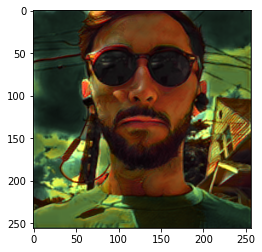

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 2699 steps. Total loss: 477472.6875. Style Loss: 141727.390625. Content Loss: 335745.28125


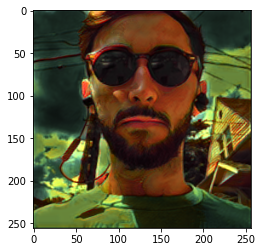

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 2999 steps. Total loss: 453082.3125. Style Loss: 129631.46875. Content Loss: 323450.84375


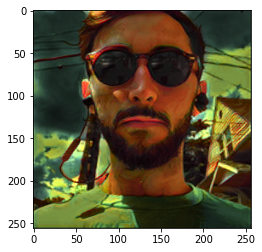

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 3299 steps. Total loss: 450070.125. Style Loss: 126077.3359375. Content Loss: 323992.78125


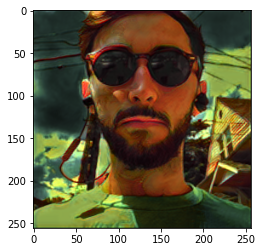

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 3599 steps. Total loss: 424754.96875. Style Loss: 118773.3359375. Content Loss: 305981.625


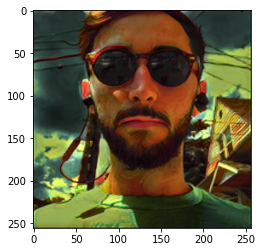

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 3899 steps. Total loss: 416545.1875. Style Loss: 118089.9765625. Content Loss: 298455.21875


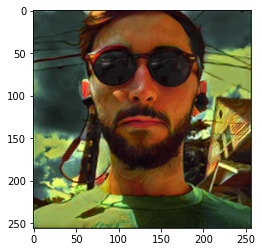

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 4199 steps. Total loss: 404094.375. Style Loss: 109357.609375. Content Loss: 294736.78125


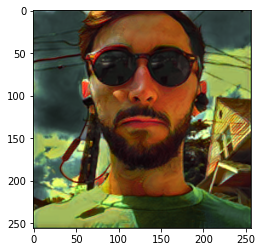

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 4499 steps. Total loss: 414506.15625. Style Loss: 120237.5703125. Content Loss: 294268.59375


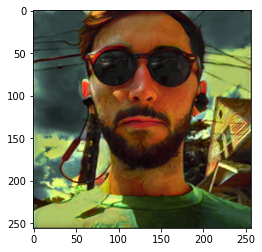

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 4799 steps. Total loss: 390729.9375. Style Loss: 104470.53125. Content Loss: 286259.40625


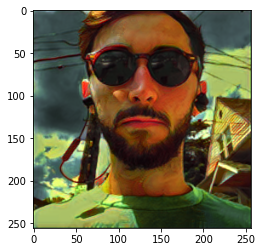

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 5099 steps. Total loss: 383200.25. Style Loss: 104811.5546875. Content Loss: 278388.6875


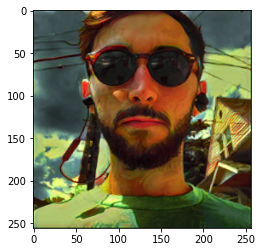

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 5399 steps. Total loss: 378932.28125. Style Loss: 103555.3515625. Content Loss: 275376.9375


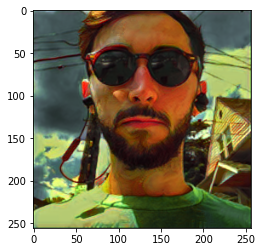

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 5699 steps. Total loss: 375330.9375. Style Loss: 104672.625. Content Loss: 270658.3125


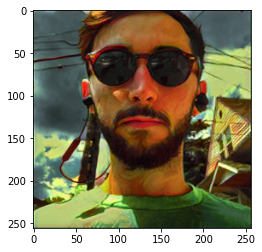

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 5999 steps. Total loss: 369399.8125. Style Loss: 98093.953125. Content Loss: 271305.84375


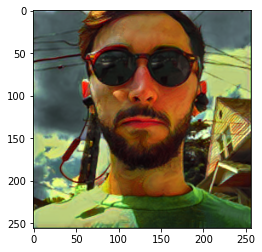

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 6299 steps. Total loss: 362808.84375. Style Loss: 99341.90625. Content Loss: 263466.9375


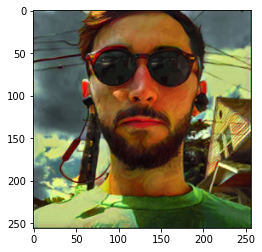

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 6599 steps. Total loss: 360445.75. Style Loss: 99371.4921875. Content Loss: 261074.25


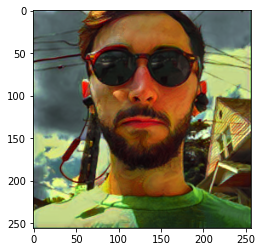

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 6899 steps. Total loss: 359324.84375. Style Loss: 100980.0703125. Content Loss: 258344.765625


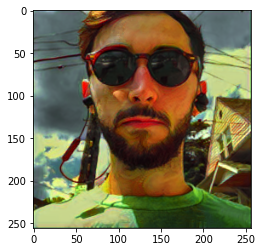

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 7199 steps. Total loss: 371789.96875. Style Loss: 103357.0390625. Content Loss: 268432.9375


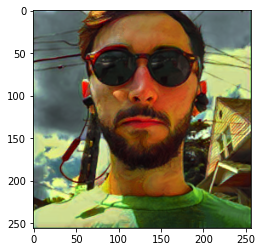

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 7499 steps. Total loss: 349884.96875. Style Loss: 96431.953125. Content Loss: 253453.015625


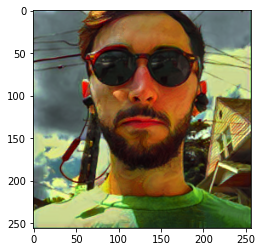

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 7799 steps. Total loss: 347023.25. Style Loss: 94195.2265625. Content Loss: 252828.03125


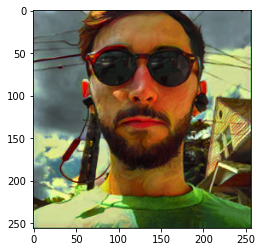

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 8099 steps. Total loss: 345771.09375. Style Loss: 94373.40625. Content Loss: 251397.6875


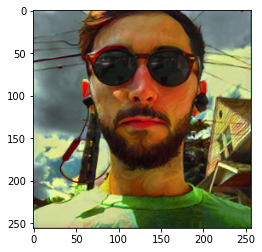

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 8399 steps. Total loss: 351719.1875. Style Loss: 99475.4453125. Content Loss: 252243.75


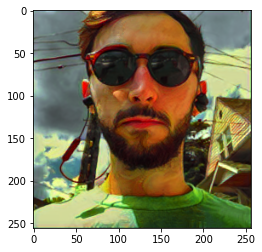

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 8699 steps. Total loss: 341285.25. Style Loss: 93306.796875. Content Loss: 247978.46875


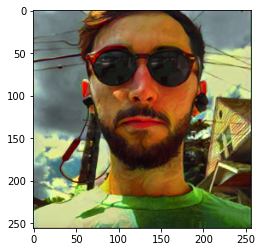

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 8999 steps. Total loss: 340393.125. Style Loss: 88556.0234375. Content Loss: 251837.109375


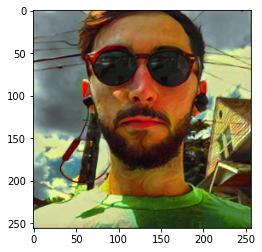

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 9299 steps. Total loss: 341057.6875. Style Loss: 89933.6953125. Content Loss: 251124.0


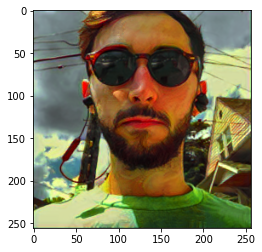

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 9599 steps. Total loss: 335119.3125. Style Loss: 90690.109375. Content Loss: 244429.203125


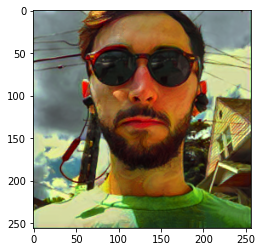

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 9899 steps. Total loss: 339028.3125. Style Loss: 91720.1640625. Content Loss: 247308.15625


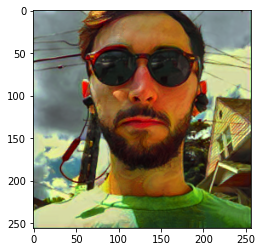

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 10199 steps. Total loss: 332355.375. Style Loss: 91406.7578125. Content Loss: 240948.625


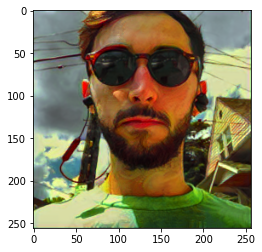

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 10499 steps. Total loss: 339178.5. Style Loss: 101072.265625. Content Loss: 238106.25


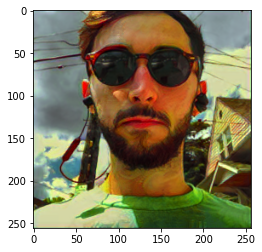

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 10799 steps. Total loss: 330759.40625. Style Loss: 89256.125. Content Loss: 241503.28125


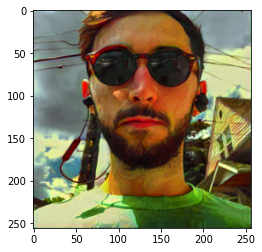

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 11099 steps. Total loss: 331944.25. Style Loss: 91083.1015625. Content Loss: 240861.15625


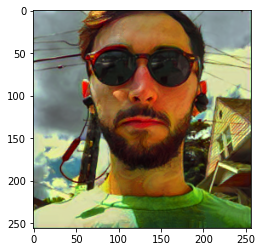

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 11399 steps. Total loss: 332351.6875. Style Loss: 92720.0625. Content Loss: 239631.625


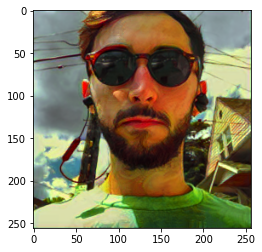

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 11699 steps. Total loss: 330155.8125. Style Loss: 94568.9375. Content Loss: 235586.875


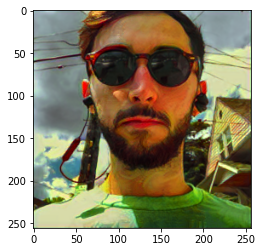

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 11999 steps. Total loss: 328139.78125. Style Loss: 87644.1328125. Content Loss: 240495.640625


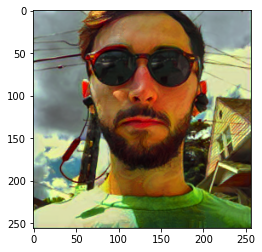

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 12299 steps. Total loss: 326651.53125. Style Loss: 89502.625. Content Loss: 237148.90625


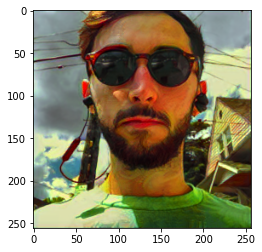

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 12599 steps. Total loss: 327945.5. Style Loss: 92311.640625. Content Loss: 235633.84375


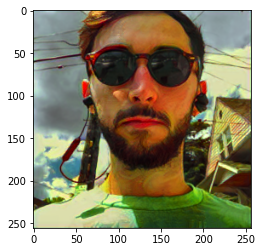

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 12899 steps. Total loss: 325621.8125. Style Loss: 88330.0. Content Loss: 237291.8125


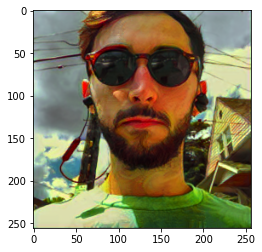

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 13199 steps. Total loss: 325085.59375. Style Loss: 89580.6015625. Content Loss: 235504.984375


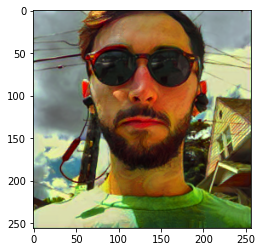

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 13499 steps. Total loss: 323597.5625. Style Loss: 87133.265625. Content Loss: 236464.28125


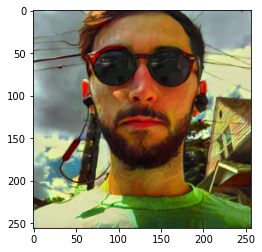

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 13799 steps. Total loss: 325295.34375. Style Loss: 92156.5546875. Content Loss: 233138.796875


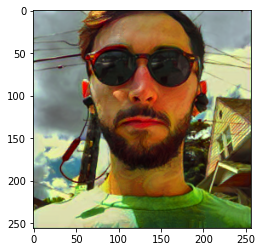

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 14099 steps. Total loss: 324194.1875. Style Loss: 84140.9296875. Content Loss: 240053.265625


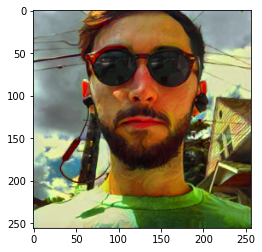

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 14399 steps. Total loss: 359785.71875. Style Loss: 101842.109375. Content Loss: 257943.609375


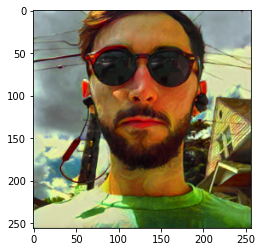

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 14699 steps. Total loss: 323119.84375. Style Loss: 87729.1015625. Content Loss: 235390.734375


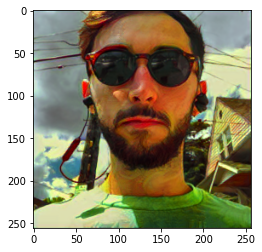

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 14999 steps. Total loss: 326103.625. Style Loss: 85268.71875. Content Loss: 240834.921875


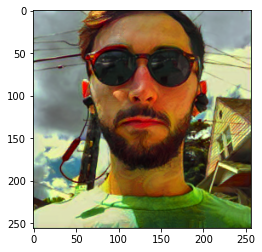

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 15299 steps. Total loss: 320611.59375. Style Loss: 87216.1796875. Content Loss: 233395.40625


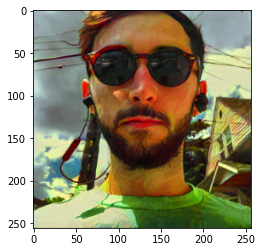

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 15599 steps. Total loss: 329126.25. Style Loss: 90368.625. Content Loss: 238757.640625


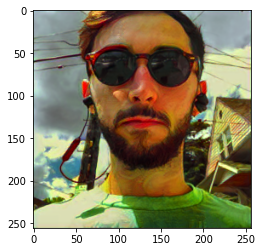

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 15899 steps. Total loss: 330800.125. Style Loss: 88702.3203125. Content Loss: 242097.8125


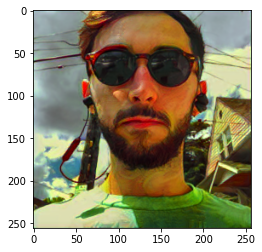

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 16199 steps. Total loss: 321148.5. Style Loss: 86376.4375. Content Loss: 234772.0625


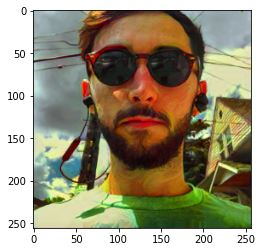

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 16499 steps. Total loss: 319162.59375. Style Loss: 88474.8203125. Content Loss: 230687.765625


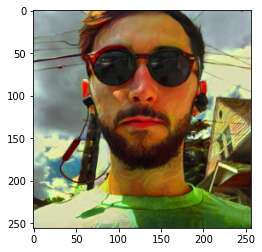

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 16799 steps. Total loss: 318837.625. Style Loss: 87355.921875. Content Loss: 231481.6875


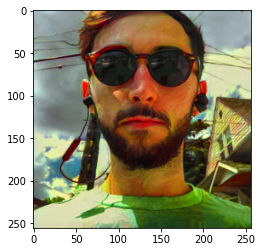

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 17099 steps. Total loss: 320218.4375. Style Loss: 84661.359375. Content Loss: 235557.078125


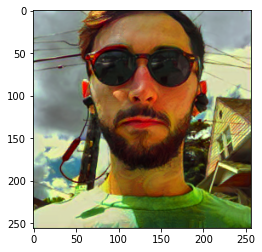

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 17399 steps. Total loss: 346603.40625. Style Loss: 99312.3125. Content Loss: 247291.09375


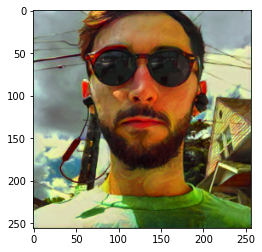

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 17699 steps. Total loss: 317717.5. Style Loss: 84881.4765625. Content Loss: 232836.015625


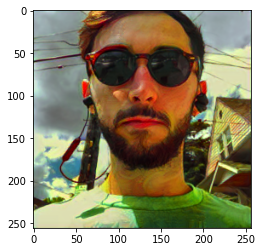

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 17999 steps. Total loss: 318152.9375. Style Loss: 86340.953125. Content Loss: 231812.0


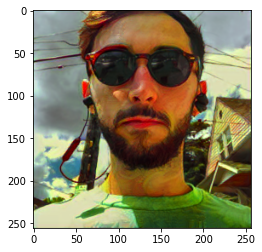

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 18299 steps. Total loss: 343696.90625. Style Loss: 92415.6328125. Content Loss: 251281.28125


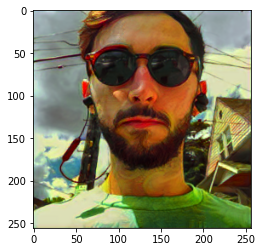

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 18599 steps. Total loss: 316849.25. Style Loss: 85342.8984375. Content Loss: 231506.34375


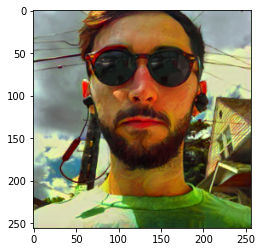

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 18899 steps. Total loss: 316784.59375. Style Loss: 85094.5078125. Content Loss: 231690.078125


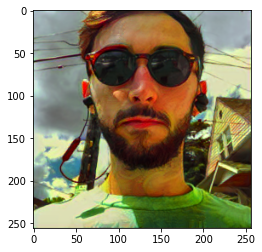

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 19199 steps. Total loss: 316181.875. Style Loss: 87617.953125. Content Loss: 228563.90625


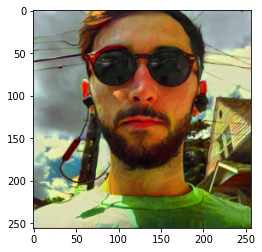

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 19499 steps. Total loss: 316914.9375. Style Loss: 85385.28125. Content Loss: 231529.671875


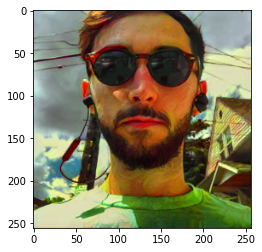

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 19799 steps. Total loss: 316917.0625. Style Loss: 85387.1953125. Content Loss: 231529.859375


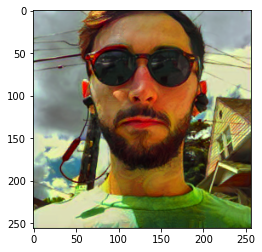

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 20099 steps. Total loss: 320145.4375. Style Loss: 85851.078125. Content Loss: 234294.359375


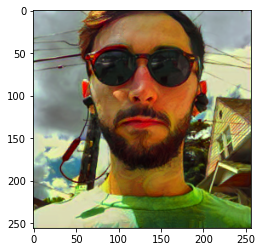

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 20399 steps. Total loss: 314927.34375. Style Loss: 86939.2421875. Content Loss: 227988.09375


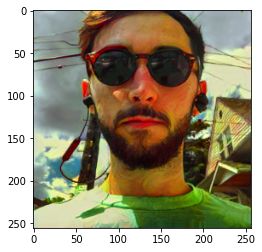

In [0]:
style_losses, content_losses, sum_losses, gif_images = [],[],[],[]

for step in range(TOTAL_STEPS):
  optimizer.zero_grad()
  prediction = style_model(content_image_input)
  prediction.requires_grad_(True)

  normalized_prediction = utils.normalize_batch(prediction, inplace=False)
  prediction_features = feature_extractor(normalized_prediction)

  content_loss = F.mse_loss(prediction_features.relu2_2, content_image_features.relu2_2)
  content_loss *= CONTENT_WEIGHT

  style_loss_sum = 0.
  for i, (prediction_feature_layer, style_image_gram_layer) in enumerate(zip(prediction_features, style_image_gram_matrix)):
    prediction_gram_matrix = utils.gram_matrix(prediction_feature_layer)
    style_image_gram_layer = style_image_gram_layer.type_as(prediction_feature_layer)
    c, h, w = prediction_gram_matrix.shape

    style_loss_layer = F.mse_loss(prediction_gram_matrix, style_image_gram_layer[:1, :, :])
    style_loss_layer *= LAYER_WEIGHTS[i]
    # style_loss_layer /= (c*h*w)
    style_loss_sum += style_loss_layer
  
  style_loss_sum *= STYLE_WEIGHT
  style_losses.append(style_loss_sum.item())
  content_losses.append(content_loss.item())

  loss_sum = content_loss + style_loss_sum
  sum_losses.append(loss_sum.item())

  if (step+1) % PRINT_EVERY == 0:
    gif_images.append(prediction.detach())
    print(f"After {step} steps. Total loss: {loss_sum.item()}. Style Loss: {style_loss_sum.item()}. Content Loss: {content_loss.item()}")
    plt.imshow(prediction.detach().div(255).squeeze(0).permute(1,2,0).cpu().numpy())
    plt.show()

  
  loss_sum.backward()
  optimizer.step()


In [92]:
gif_np_images = list(map(lambda x: x.div(255).squeeze(0).permute(1,2,0).cpu().numpy(), gif_images))

imageio.mimsave("./style_optimization.gif", gif_np_images)
torchvision.utils.save_image(prediction, "./final_stylized.png", normalize=True)